# Ref MeSH Builder

 This notebook allows you to create MeSH lists to inquire the GRPM Dataset starting with a biomedical topic of choice.
 The system is based on the complete MESH datasheet.
 The system uses ChatGPT API to supply the initial biomedical terms for constructing the Ref MeSH set.

# Import Packages

In [2]:
import importlib
import subprocess

try:
    importlib.import_module('pygrpm')
except ImportError:
    subprocess.check_call(["pip", "install", "git+https://github.com/johndef64/GRPM_system.git"])

from pygrpm import *

import os
import glob
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

current_directory = os.getcwd()
print("Current working directory:", current_directory)

def simple_bool(message):
    choose = input(message+" (y/n): ").lower()
    your_bool = choose in ["y", "yes","yea","sure"]
    return your_bool

def get_file(url, file_name, dir = os.getcwd()):
    url = url
    file_name = file_name
    response = requests.get(url)
    if response.status_code == 200:
        content = response.content
        file_path = os.path.join(dir, file_name)
        with open(file_path, 'wb') as file:
            file.write(content)



Current working directory: G:\Altri computer\Horizon\horizon_workspace\projects\work\semantics\GRPM\GRPM_github


# Get requirements

## Get MESH.csv from 'bioportal.bioontology.org'

In [ ]:
import gzip
import shutil
# Get MESH.csv from https://bioportal.bioontology.org/ontologies/MESH?p=summary

if not os.path.exists('ref-mesh'):
    os.makedirs('ref-mesh')

if not os.path.exists('ref-mesh/MESH.csv'):
    get_file( url='https://data.bioontology.org/ontologies/MESH/download?apikey=8b5b7825-538d-40e0-9e9e-5ab9274a9aeb&download_format=csv', file_name='MESH.gz', dir = 'ref-mesh')

    # Open the gzipped input file and the output file
    file_path = 'ref-mesh/'
    with gzip.open(file_path+'MESH.gz', 'rb') as input_file, open(file_path+'MESH.csv', 'wb') as output_file:
        # Copy the content from the input gzipped file to the output file
        shutil.copyfileobj(input_file, output_file)
    
    os.remove(file_path+'MESH.gz')

## Get pre-made datasets from Zenodo

In [6]:
# Get pre-made datasets from Zenodo Repository
#https://zenodo.org/record/8205724  DOI: 10.5281/zenodo.8205724
dataset_releases = {'0.1':'8205724',
                    '0.2':'14052302'}
    
if not os.path.exists('ref-mesh/MESH_STY_LITVAR1.csv'):
    get_and_extract('ref-mesh', record_id=dataset_releases['0.2'])

14052302


Downloading...
From: https://zenodo.org/record/14052302/files/ref-mesh.zip?download=1
To: G:\Altri computer\Horizon\horizon_workspace\projects\work\semantics\GRPM\GRPM_github\ref-mesh.zip
100%|██████████| 4.02M/4.02M [00:01<00:00, 3.23MB/s]


Extracting...
ZIP file 'ref-mesh.zip' extracted in 'G:\Altri computer\Horizon\horizon_workspace\projects\work\semantics\GRPM\GRPM_github' successfully.


# 1. Load Mesh full dataset
(skip this if MESH.csv is not provided)

In [4]:
#load MESH dataframe:
if os.path.exists('ref-mesh/MESH.csv'):
    df = pd.read_csv('ref-mesh/MESH.csv', low_memory=False)
else:
    print("no MESH.csv available.\n => skip to Section 2")

#info on Proprieties: https://bioportal.bioontology.org/ontologies/MESH?p=properties
#Mesh Browser: https://meshb.nlm.nih.gov/

# AQL: Allowable Qualifiers
AQL = ["blood (BL)","cerebrospinal fluid (CF)","chemically induced (CI)","classification (CL)","complications (CO)","congenital (CN)","diagnosis (DI)","diagnostic imaging (DG)","diet therapy (DH)","drug therapy (DT)","economics (EC)","embryology (EM)","enzymology (EN)","epidemiology (EP)","ethnology (EH)","etiology (ET)","genetics (GE)","history (HI)","immunology (IM)","metabolism (ME)","microbiology (MI)","mortality (MO)","nursing (NU)","parasitology (PS)","pathology (PA)","physiopathology (PP)","prevention & control (PC)","psychology (PX)","radiotherapy (RT)","rehabilitation (RH)","surgery (SU)","therapy (TH)","urine (UR)","veterinary (VE)","virology (VI)"]
aql=pd.DataFrame(AQL)
aql

,0
0,blood (BL)
1,cerebrospinal fluid (CF)
2,chemically induced (CI)
3,classification (CL)
4,complications (CO)
5,congenital (CN)
6,diagnosis (DI)
7,diagnostic imaging (DG)
8,diet therapy (DH)
9,drug therapy (DT)


In [5]:
print('display MeSH data:\n')
df.head()

display MeSH data:


,Class ID,Preferred Label,Synonyms,Definitions,Obsolete,CUI,Semantic Types,Parents,AN,AQL,...,OL,PA,PI,RR,SC,Scope Statement,Semantic type UMLS property,SRC,TERMUI,TH
0,http://purl.bioontology.org/ontology/MESH/C039049,UP 5-207,"Phenol, 4,4'-(1-methylethylidene)bis-, polymer...",NaN,False,C0619384,http://purl.bioontology.org/ontology/STY/T109,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,epoxy glue,http://purl.bioontology.org/ontology/STY/T109,Gig Tr Prof Zabol 1983;(7):54,T147161|T147162,NLM (1983)
1,http://purl.bioontology.org/ontology/MESH/C039048,manganese-zinc ferrite,NaN,NaN,False,C0065653,http://purl.bioontology.org/ontology/STY/T197,NaN,NaN,NaN,...,NaN,NaN,*MANGANESE (83-93)|*ZINC (83-93),NaN,1.0,NaN,http://purl.bioontology.org/ontology/STY/T197,Gig Sanit 1983;(6):13,T147160,NLM (1983)
2,http://purl.bioontology.org/ontology/MESH/C039047,"2,3,6-trichlorotoluene","2,3,6-TCT",NaN,False,C0045332,http://purl.bioontology.org/ontology/STY/T109,NaN,NaN,NaN,...,NaN,NaN,NaN,"2077-46-5 (2,3,6-trichlorotoluene)",1.0,NaN,http://purl.bioontology.org/ontology/STY/T109,Gig Sanit 1983;(6):61,T147158|T147159,INN (19XX)|FDA SRS (2015)|NLM (1983)
3,http://purl.bioontology.org/ontology/MESH/C039046,"2,3,6-trichloro-4-tert-butyltoluene","2,3,6-TTBT|Benzene, 1,3,4-trichloro-5-(1,1-dim...",NaN,False,C0619382,http://purl.bioontology.org/ontology/STY/T109,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,http://purl.bioontology.org/ontology/STY/T109,Gig Sanit 1983;(6):61,T147156|T147157,NLM (1983)
4,http://purl.bioontology.org/ontology/MESH/C039040,ethiodized oil emulsion 13,ethiodiol|EOE 13|EOE-13,NaN,False,C0059720|C0116736,http://purl.bioontology.org/ontology/STY/T109|...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,used for detection of tumors in liver & spleen,http://purl.bioontology.org/ontology/STY/T109|...,J Comput Assist Tomogr 1983;7(5):905,T147143|T147142|T147140|T147141,NLM (1983)


In [ ]:
#How many MeSH has mapping qualifier (subheadings)?
all_mesh = df['Preferred Label'].drop_duplicates()
mapping_qf = df[['Mapping qualifier of','Preferred Label']].drop_duplicates().dropna()
has = df[['Has mapping qualifier','Preferred Label']].drop_duplicates().dropna()
has_len = has['Preferred Label'].nunique()

print('Total number of MeSH terms:\n', df['Preferred Label'].nunique())
print('\nHow many Mesh has mapping qualifier (subheadings)?\n',has_len)
print(' %', round((has_len/len(all_mesh)*100),3))

In [ ]:
# search for single exact value
mesh = 'Disease or Syndrome'
mesh = 'Heart Failure'
print('search for single exact value:')
df[df['Preferred Label']==mesh].T.dropna()

In [ ]:
#Extract subset of Mesh
str_1 = 'Fabry'
str_2 = 'Lysosomal Sto'
str_3 = ''
str_full = str_2 or str_1 or str_3

ref_search = df[df['Preferred Label'].str.contains(str_full).fillna(False)]
print('look for mesh containing "',str_1,',',str_2,',',str_3,  '":')
ref_search

## Semantic Types Analysis

In [ ]:
#Extract subset of all semantic types
df_sem = df[df['Class ID'].str.contains('STY').fillna(False)]
df_sem

#### Characterize a Semantic Type

In [6]:
#how many mesh for semantic type?
semantictype = 'T192'
sam_label = df[df['Class ID'].str.contains(semantictype).fillna(False)].reset_index().at[0,'Preferred Label']
# Get Semantic Type name for STY ID
print('semantic type:', sam_label)

mask2 = df['Semantic Types'].str.contains(semantictype).fillna(False)
mesh_sem = df[mask2][['Class ID','Preferred Label','Definitions','Semantic Types']]
print('number of mesh:', len(mesh_sem))
print('\nMesh for "',semantictype,sam_label,'" semantic type:')

mesh_sem

semantic type: Receptor
number of mesh: 4617

Mesh for " T192 Receptor " semantic type:


C:\Users\Utente\AppData\Local\Temp\ipykernel_13968\985110198.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask2 = df['Semantic Types'].str.contains(semantictype).fillna(False)


,Class ID,Preferred Label,Definitions,Semantic Types
157,http://purl.bioontology.org/ontology/MESH/C033482,serum thymic factor receptor,NaN,http://purl.bioontology.org/ontology/STY/T116|...
488,http://purl.bioontology.org/ontology/MESH/C491405,"TNFRSF18 protein, human",NaN,http://purl.bioontology.org/ontology/STY/T116|...
557,http://purl.bioontology.org/ontology/MESH/C116483,"plexA protein, Drosophila",NaN,http://purl.bioontology.org/ontology/STY/T116|...
560,http://purl.bioontology.org/ontology/MESH/C116484,"plexB protein, Drosophila",NaN,http://purl.bioontology.org/ontology/STY/T116|...
626,http://purl.bioontology.org/ontology/MESH/C087430,"22.6-kDa antigen, Schistosoma japonicum",NaN,http://purl.bioontology.org/ontology/STY/T116|...
...,...,...,...,...
353374,http://purl.bioontology.org/ontology/MESH/C515077,"KIR2DL2 protein, human",NaN,http://purl.bioontology.org/ontology/STY/T116|...
353739,http://purl.bioontology.org/ontology/MESH/C030708,triazine herbicide receptor,NaN,http://purl.bioontology.org/ontology/STY/T116|...
353784,http://purl.bioontology.org/ontology/MESH/C112493,"EGL-15 protein, C elegans",NaN,http://purl.bioontology.org/ontology/STY/T116|...
353822,http://purl.bioontology.org/ontology/MESH/D047629,Estrogen Receptor beta,One of the ESTROGEN RECEPTORS that has greater...,http://purl.bioontology.org/ontology/STY/T116|...


#### Characterize a single mesh

In [7]:
# search for single Mesh
mesh_classid ='D004048'
maskmesh = df['Class ID'].str.contains(mesh_classid).fillna(False)

sty_classid = df[maskmesh]['Semantic Types'].reset_index().iat[0, 1][-4:]

masksty = df['Class ID'].str.contains(sty_classid).fillna(False)

masked = df[maskmesh][['Semantic Types','Preferred Label','Definitions']].reset_index()

#get mesh definition:
print('mesh:', masked.at[0,'Preferred Label'],
      '\nsemantic type:',df[masksty].reset_index().at[0,'Preferred Label'],sty_classid,
      '\ndescrition:',masked.at[0,'Definitions'])

mesh: Diethylamines 
semantic type: Organic Chemical T109 
descrition: Diethylamine with the formula CH3CH2NHCH2CH3 and its derivatives.


In [ ]:
# Row aggregation
data_mesh = []
data_sty = ['T021','T116']
dfd = pd.DataFrame()
for i in data_sty:
    mask = df['Semantic Types'].str.contains(i).fillna(False) # aggregate mesh for sty
    dfd = pd.concat([dfd, df[mask]])
dfd

# 2. Load/create MESH-LITVAR dataset (required)

In [9]:
# Subset MeSH dataset

#set options:
import_mesh_sty = True

# concat the exploded mesh table or import prearranged csv
if os.path.isfile('ref-mesh/MESH_STY.csv') and import_mesh_sty:
    mesh_large_df_sty = pd.read_csv('ref-mesh/MESH_STY.csv', index_col=0)
    print('MESH_STY sty imported from csv')
elif import_mesh_sty:
        if os.path.exists('ref-mesh/MESH.csv'):
            # correct list format
            df['STY_ID'] = df['Semantic Types'].str.replace(r'http://purl.bioontology.org/ontology/STY/','', regex = False)
            start_word = '[\"'
            end_word = '\"]'
            df['STY_ID'] = f'{start_word} ' + df['STY_ID'] + f' {end_word}'
            df['STY_ID'] = df['STY_ID'].str.replace(' ','', regex = False)
            df['STY_ID'] = df['STY_ID'].str.replace('|','\",\"', regex = False)
            #print(df['STY_ID'].isna().sum())
            df.dropna(subset=['STY_ID'], inplace=True)
            df.reset_index(drop=True,inplace=True)

            from ast import literal_eval
            df['STY_ID'] = df['STY_ID'].apply(literal_eval)

            # Import exhcange table sty-code
            sty = pd.read_csv('ref-mesh/MeshSTY-code.csv',sep=';')
            sty = sty.rename(columns={'ID':'Semantic Types'})
            sty = sty.rename(columns={'ID':'Semantic Types'})
            #print(sty['Semantic Types'].nunique())

            #mesh_large = pd.DataFrame()
            mesh_large = []
            for i in range(len(df)):
                for sem in df['STY_ID'][i]: #dfrspost = mother table
                    out = df['Preferred Label'][i],df['Class ID'][i],sem,df['Synonyms'][i],df['Parents'][i],df['CUI'][i],df['AQL'][i],df['TERMUI'][i]
                    mesh_large.append(out)

            mesh_large_df = pd.DataFrame(mesh_large)
            new_col_names = ['Preferred Label','Class ID','Semantic Types','Synonyms','Parents','CUI','AQL','TERMUI']
            mesh_large_df.columns = new_col_names

            ## Add STY Labels
            mesh_large_df_sty = pd.merge(mesh_large_df, sty, on='Semantic Types', how='inner').reset_index(drop=True)
            #Add rsid coulmn con merge
            mesh_large_df_sty = mesh_large_df_sty.rename(columns={'Preferred Label_y':'Semantic Types Label','Preferred Label_x':'Preferred Label'})

            mesh_large_df_sty = mesh_large_df_sty[['Preferred Label', 'Semantic Types Label', 'Class ID', 'Semantic Types', 'Synonyms', 'Parents', 'CUI', 'AQL', 'TERMUI']]
            mesh_large_df_sty.to_csv('ref-mesh/MESH_STY.csv')
            print('MESH_STY created')
        else:
            print('MESH.csv not available')

#---------------------------------------------------
#### Create MESH-STY-LITVAR subset from MESH-STY.csv
if os.path.exists('ref-mesh/MESH_STY_LITVAR1.csv'):
    mesh_litvar_sty = pd.read_csv('ref-mesh/MESH_STY_LITVAR1.csv',index_col=0)
    print('MESH_STY_LITVAR1 imported from csv')
else:
    grpm_mesh = pd.read_csv('ref-mesh/grpm_db_mesh.csv', index_col=0)
    mask = mesh_large_df_sty['Preferred Label'].isin(grpm_mesh.mesh)
    mesh_litvar_sty = mesh_large_df_sty[mask]
    mesh_litvar_sty.to_csv('ref-mesh/MESH_STY_LITVAR1.csv')
    print('MESH_STY_LITVAR1 created')

print('\n => For Reference MeSH list definition skip to Section 3')

MESH_STY sty imported from csv
MESH_STY_LITVAR1 imported from csv

 => For Reference MeSH list definition skip to Section 3


In [ ]:
# MeSH stats
if 'mesh_large_df_sty' in globals():
    print('MESH_STY', mesh_large_df_sty['Preferred Label'].nunique(), 'mesh')
    print('MESH_STY', mesh_large_df_sty['Semantic Types Label'].nunique(), 'semantic types')

print('MESH_STY_LITVAR1', mesh_litvar_sty['Preferred Label'].nunique(), 'mesh')
print('MESH_STY_LITVAR1', mesh_litvar_sty['Semantic Types Label'].nunique(), 'semantic types\n')

mesh_litvar_sty[['Preferred Label', 'Semantic Types Label', 'Class ID', 'mesh_id','Semantic Types']]#.columns

In [ ]:
## ADD mesh_id col
if 'mesh_id' not in mesh_litvar_sty.columns:
    mesh_litvar_sty['mesh_id'] = mesh_litvar_sty['Class ID'].str.replace('http://purl.bioontology.org/ontology/MESH/', '')
    mesh_litvar_sty['mesh_id']
    mesh_litvar_sty.columns
    new_order = ['Preferred Label', 'Semantic Types Label', 'Class ID', 'mesh_id', 'Semantic Types',
                 'Synonyms', 'Parents', 'CUI', 'AQL', 'TERMUI']
    mesh_litvar_sty = mesh_litvar_sty[new_order]
    mesh_litvar_sty.to_csv('ref-mesh/MESH_STY_LITVAR1.csv')
else:
    print('mesh_id aready added to csv')

## Add mesh_id to GRPM dataset (not required)

In [10]:
print("note: in GRPM Dataset screening using 'Preferred Label' results faster then numerical 'mesh_id'")

if simple_bool("note: in GRPM Dataset screening using 'Preferred Label' results faster then numerical 'mesh_id'\n add mesh_id to grpm_ds and replace 'Preferred Label' anyway?") and os.path.exists('grpm_dataset/grpm_db_pcg/grpm_table_output.csv'):
    grpm_b_df = pd.read_parquet('grpm_dataset/grpm_dataset.parquet')

    if not 'mesh_id' in grpm_b_df.columns:
        # add mesh_id to grpm db
        mesh_id_ref_df = mesh_litvar_sty[['Preferred Label','mesh_id']]
        grpm_db_merge_id = pd.merge(grpm_b_df, mesh_id_ref_df, left_on='mesh', right_on='Preferred Label')

        # replace 'Preferred Label' with 'mesh_id'
        grpm_db_merge_id = grpm_db_merge_id.drop('Preferred Label', axis=1)
        grpm_db_merge_id.columns
        new_order = ['gene', 'rsid', 'pmid', 'mesh_id']
        grpm_db_merge_id = grpm_db_merge_id[new_order].drop_duplicates()
        grpm_db_merge_id

note: in GRPM Dataset screening using 'Preferred Label' results faster then numerical 'mesh_id'


In [ ]:
if simple_bool('save it?'):
    grpm_db_merge_id.to_parquet('grpm_dataset/grpm_datset_id.parquet')

In [ ]:
if simple_bool('check?'):
    check = pd.read_parquet('grpm_dataset/grpm_datset_id.parquet')
    check

### Sorting Mesh-STY

In [11]:
if 'mesh_large_df_sty' in globals():
    # groupby and bar module
    mesh_large_df_sty_less = mesh_large_df_sty[['Preferred Label','Semantic Types Label']]

    ### groupby.describe analysis by rsid--------------------
    mesh_large_df_sty_less_count = mesh_large_df_sty_less.groupby('Semantic Types Label').describe().reset_index()
    mesh_large_df_sty_less_count.columns = mesh_large_df_sty_less_count.columns.to_flat_index()
    new_column_names = ['Semantic Types Label', 'mesh-count', 'mesh-unique','mesh-top','mesh-freq']
    mesh_large_df_sty_less_count.columns = new_column_names

    mesh_large_df_sty_less_count_sort = mesh_large_df_sty_less_count.sort_values(by='mesh-count',ascending=False).reset_index(drop=True)
    print('MESH_STY')
    print('Semantic Type count:',len(mesh_large_df_sty_less_count_sort),'\n\nMeSH count for Sty:')
    display(mesh_large_df_sty_less_count_sort[['mesh-count','Semantic Types Label']])

MESH_STY
Semantic Type count: 126 

MeSH count for Sty:


,mesh-count,Semantic Types Label
0,136114,Organic Chemical
1,104554,"Amino Acid, Peptide, or Protein"
2,62414,Biologically Active Substance
3,60593,Pharmacologic Substance
4,45706,Fungus
...,...,...
121,4,Vertebrate
122,3,Drug Delivery Device
123,3,Human
124,2,Entity


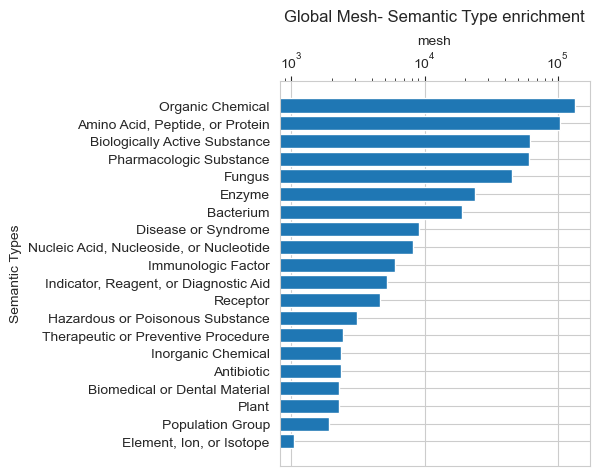

In [12]:
#Graph Barh
num = 20
x = mesh_large_df_sty_less_count_sort['Semantic Types Label'].iloc[:num]
y = mesh_large_df_sty_less_count_sort['mesh-count'].iloc[:num]
plt.figure(figsize=(4, len(x) *0.25))
plt.title('Global Mesh- Semantic Type enrichment', loc='center',pad=10)

plt.barh(x,y)
plt.gca().invert_yaxis()
plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
#plt.xlabel('pmid count', position=(0.5, 1.08))
plt.ylabel('Semantic Types')
plt.xlabel('mesh', position=(0.5, 1.08))
ax = plt.gca()
ax.xaxis.set_label_position('top')
# use log scale
plt.gca().set_xscale('log')
#plt.savefig('Reference Mesh- Semantic Type enrichment.png',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
#'Global "Mesh-Semantic Type" Zipf s law'
x = mesh_large_df_sty_less_count_sort['Semantic Types Label'].iloc[:]
y = mesh_large_df_sty_less_count_sort['mesh-count'].sort_values().iloc[:]
plt.figure(figsize=(6, 5))
plt.title('Global "Mesh-Semantic Type" Zipf s law', loc='center',pad=10)

plt.plot(x,y)
plt.gca().invert_yaxis()

plt.ylabel('mesh number')
plt.xlabel('semantic type rank', position=(0.5, 1.08))

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.show()

In [ ]:
## Density Rugged Plot
data = mesh_large_df_sty_less_count_sort['mesh-count'].iloc[:]

sns.set_style('whitegrid')
sns.kdeplot(np.array(data), bw_method=0.5)
sns.rugplot(np.array(data), color='r')

#plt.yscale('log')
plt.title('Mesh abundance for Semantic Type')
#plt.yscale('log')
print('Mesh abundance for Semantic Type:')
plt.show()

## Analyze MESH-STY-LITVAR (subset of MESH-STY.csv)

In [ ]:
print('mesh_litvar_sty mesh:',mesh_litvar_sty['Preferred Label'].nunique())

memory = mesh_litvar_sty.memory_usage().sum()
print(f'The memory_usage of mesh_litvar_sty is {memory/ (1024 * 1024):.2f} MB.')

file_size = os.path.getsize('ref-mesh/MESH_STY_LITVAR1.csv')
print(f'The size of MESH_STY_LITVAR1.csv is {file_size/ (1024 * 1024):.2f} MB.')

#### Sort MeSH-Sty-Litvar

In [ ]:
# groupby and bar module
mesh_litvar_sty_less = mesh_litvar_sty[['Preferred Label','Semantic Types Label']]

### groupby.describe analysis by rsid--------------------
mesh_litvar_sty_less_count = mesh_litvar_sty_less.groupby('Semantic Types Label').describe().reset_index()
mesh_litvar_sty_less_count.columns = mesh_litvar_sty_less_count.columns.to_flat_index()
new_column_names = ['Semantic Types Label', 'mesh-count', 'mesh-unique','mesh-top','mesh-freq']
mesh_litvar_sty_less_count.columns = new_column_names

mesh_litvar_sty_less_count_sort = mesh_litvar_sty_less_count.sort_values(by='mesh-count',ascending=False).reset_index(drop=True)
print('MESH_STY_LITVAR1')
mesh_litvar_sty_less_count_sort[['mesh-count','Semantic Types Label']]#.to_clipboard()

In [ ]:
#Graph Barh
num = 20
x = mesh_litvar_sty_less_count_sort['Semantic Types Label'].iloc[:num]
y = mesh_litvar_sty_less_count_sort['mesh-count'].iloc[:num]
plt.figure(figsize=(4, len(x)*0.25))
plt.title('Litvar1 Mesh- Semantic Type enrichment', loc='center',pad=10)

plt.barh(x,y)
plt.gca().invert_yaxis()
plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
plt.ylabel('Semantic Types')
plt.xlabel('mesh', position=(0.5, 1.08))
ax = plt.gca()
ax.xaxis.set_label_position('top')
# use log scale
plt.gca().set_xscale('log')
#plt.savefig('Reference Mesh- Semantic Type enrichment.png',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
#'Global "Mesh-Semantic Type" Zipf s law'
x = mesh_litvar_sty_less_count_sort['Semantic Types Label'].iloc[:]
y = mesh_litvar_sty_less_count_sort['mesh-count'].sort_values().iloc[:]
plt.figure(figsize=(6, 5))
plt.title('LitVar "Mesh-Semantic Type" Zipf s law', loc='center',pad=10)

plt.plot(x,y)
plt.gca().invert_yaxis()

plt.ylabel('mesh number')
plt.xlabel('semantic type rank', position=(0.5, 1.08))

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.show()

In [ ]:
# VISUALIZE DIFFERENCES

#reload sorted df
if 'mesh_large_df_sty_less_count_sort' in locals() and isinstance(mesh_large_df_sty_less_count_sort, pd.DataFrame):
    pass
else:
    mesh_large_df_sty_less = mesh_large_df_sty[['Preferred Label','Semantic Types Label']]
    mesh_large_df_sty_less_count = mesh_large_df_sty_less.groupby('Semantic Types Label').describe().reset_index()
    mesh_large_df_sty_less_count.columns = mesh_large_df_sty_less_count.columns.to_flat_index()
    new_column_names = ['Semantic Types Label', 'mesh-count', 'mesh-unique','mesh-top','mesh-freq']
    mesh_large_df_sty_less_count.columns = new_column_names
    mesh_large_df_sty_less_count_sort = mesh_large_df_sty_less_count.sort_values(by='mesh-count',ascending=False).reset_index(drop=True)
if 'mesh_litvar_sty_less_count_sort' in locals() and isinstance(mesh_litvar_sty_less_count_sort, pd.DataFrame):
    pass
else:
    mesh_litvar_sty_less = mesh_litvar_sty[['Preferred Label','Semantic Types Label']]
    mesh_litvar_sty_less_count = mesh_litvar_sty_less.groupby('Semantic Types Label').describe().reset_index()
    mesh_litvar_sty_less_count.columns = mesh_litvar_sty_less_count.columns.to_flat_index()
    new_column_names = ['Semantic Types Label', 'mesh-count', 'mesh-unique','mesh-top','mesh-freq']
    mesh_litvar_sty_less_count.columns = new_column_names
    mesh_litvar_sty_less_count_sort = mesh_litvar_sty_less_count.sort_values(by='mesh-count',ascending=False).reset_index(drop=True)

# create two sample dataframes
df1 = mesh_large_df_sty_less_count_sort[['mesh-count', 'Semantic Types Label']]
df2 = mesh_litvar_sty_less_count_sort[['mesh-count', 'Semantic Types Label']]

# add a 'source' column to each dataframe
df1['source'] = 'global'
df2['source'] = 'litvar'

# combine the dataframes
combined_df = pd.merge(df1, df2, on=['Semantic Types Label'], how='outer', suffixes=('_df1', '_df2'))

# sort the dataframe by column 'A'
#combined_df = combined_df.sort_values('mesh-count')

# reset the index
combined_df = combined_df.reset_index(drop=True)

# display the combined dataframe
combined_df = combined_df[-(combined_df['Semantic Types Label'] == 'Drug Delivery Device')]
combined_df
mesh_large_df_sty_less['Preferred Label'].nunique()
combined_df = combined_df.sort_values(by='mesh-count_df2', ascending=False).reset_index(drop=True)


# define a formatting function that generates a proportional bar
def format_bar(value):
    max_value = combined_df['mesh-count_df1'].max().max()  # get the maximum value in the dataframe
    bar_width = int(value / max_value * 100)  # calculate the width of the bar as a percentage
    return f'<div style="background-color: blue; width: {bar_width}%">{value}</div>'

def format_bar_2(value):
    max_value = combined_df['mesh-count_df2'].max().max()  # get the maximum value in the dataframe
    bar_width = int(value / max_value * 100)  # calculate the width of the bar as a percentage
    return f'<div style="background-color: blue; width: {bar_width}%">{value}</div>'

# apply the formatting function to the dataframe
df_formatted = combined_df.style.format({'mesh-count_df1': format_bar, 'mesh-count_df2': format_bar_2})

# save the formatted dataframe to an HTML file
with open('formatted_dataframe.html', 'w') as f:
    f.write(df_formatted.render())

# display the formatted dataframe
df_formatted

# 3. Reference MeSH build

Build coherent and comprehensive lists of mesh term related to different topics
- nutrigentics
- neurodegenerative diseases
- skin diseases
- infective diseases
- reproductive physiology

## Check available ref-MeSH lists:

In [13]:
#Check available refs:
folder_path = "ref-mesh"  # Replace with the actual folder path
#---------------------------

# Create a file path pattern to match CSV files
file_pattern = os.path.join(folder_path, "*.csv")

# Use glob to get a list of file paths matching the pattern
csv_files = glob.glob(file_pattern)
csv_files_name = []
# Print the list of CSV files
for file in csv_files:
    file_name = os.path.basename(file)
    csv_files_name.append(file_name)

print('Available reference mesh lists:')
csv_files_df = pd.Series(csv_files_name)
ref_files_df = csv_files_df[csv_files_df.str.contains('ref_mesh_')].reset_index(drop=True)
ref_files_df_small = csv_files_df[csv_files_df.str.contains('small_ref_mesh_ng_')].reset_index(drop=True)

file_names = [x.split('mesh_')[1].split('.csv')[0] for x in ref_files_df]
file_names

Available reference mesh lists:


['neuro',
 'neuro_grpm',
 'neuro_sty',
 'ng_aller',
 'ng_cvd',
 'ng_dmt2_ms',
 'ng_eat_taste',
 'ng_intol',
 'infect',
 'ng_nutri',
 'ng_ob_bmi',
 'ng_oxi_stress',
 'ng_vitam',
 'ng_xeno',
 'repro',
 'repro_clean',
 'heart_failure',
 'nutri_old']

## Build ref-MeSH list

In [5]:
if 'mesh_litvar_sty' not in locals():
    mesh_litvar_sty = pd.read_csv('ref-mesh/MESH_STY_LITVAR1.csv',index_col=0)
    print('MESH_STY_LITVAR1 imported from csv')
mesh_litvar_sty.head()

,Preferred Label,Semantic Types Label,Class ID,mesh_id,Semantic Types,Synonyms,Parents,CUI,AQL,TERMUI
1,Electronic Health Records,Intellectual Product,http://purl.bioontology.org/ontology/MESH/D057286,D057286,T170,"Electronic Medical Record|Medical Record, Elec...",http://purl.bioontology.org/ontology/MESH/D016347,C0079150|C2362543,CL EC ES HI IS LJ OG SD SN ST TD,T751083|T048813|T048814|T048815|T749887|T75108...
2,Consent Forms,Intellectual Product,http://purl.bioontology.org/ontology/MESH/D032962,D032962,T170,Informed Consent Documents|Informed Consent Fo...,http://purl.bioontology.org/ontology/MESH/D007...,C0009797,CL EC ES HI LJ OG SN ST TD,T466073|T021753|T466072|T450735
3,Genealogy and Heraldry,Intellectual Product,http://purl.bioontology.org/ontology/MESH/D005789,D005789,T170,Geneology and Heraldry|Heraldry and Genealogy|...,http://purl.bioontology.org/ontology/MESH/D006664,C0019232|C0017299,NaN,T017448|T017447|T017449|T017451
4,Publications,Intellectual Product,http://purl.bioontology.org/ontology/MESH/D011642,D011642,T170,Publication,http://purl.bioontology.org/ontology/MESH/D003146,C0034036,CL EC ES HI LJ SD SN ST TD,T034372
5,Pharmaceutical Services,Intellectual Product,http://purl.bioontology.org/ontology/MESH/D010593,D010593,T170,"Pharmaceutical Service|Services, Pharmaceutic|...",http://purl.bioontology.org/ontology/MESH/D006296,C0031321|C1449618,CL EC ES HI LJ OG SD SN ST TD,T552624|T031274|T031273|T031272|T031271|T03126...


### Generate Ref-MeSH from Topic Term Lists
For list of terms defined by the user: search in Preferred Labels and Synonyms corresponding mesh entry

In [14]:
# Define Biomedical topics
nutritional_topic = [['diseases and disorders realted to nutrition and diet ', 'diet, food consuption, eating behaviour and nutrition']]
infective_topic = [['infective agents, bacteria, virus and protozoan','infective diseases']]
reproductive_topic = [['reproductive system physiology','reproductive system pathology', 'Assisted reproductive technology']]
female_infertility_topic = [['female infertility, genetic imprinting and maternal effect']]

nutritional_topics = [
    ['Obesity, overweight and body weight control', 'compulsive eating behavior'],
    ['cardiovascular diseases','physiological processes realted to cardiovascular diseases','lipid metabolism in the context of cardiovascular diseases'],
    ['Diabetes Melitus Type II and metabolic syndrome'],
    ['Vitamin metabolism and Vitamins recommended intake levels','Micronutrients metabolism and Micronutrient recommended intake levels', 'disease related to vitamins and micronutrients deficiency'],
    ['eating behaviour and taste sensation'],
    ['food intolerances'],
    ['food allergies'],
    ['diet-induced oxidative stress'],
    ['metabolism of xenobiotics'],
]
chosen_topic = nutritional_topics
pd.Series(chosen_topic)

0    [Obesity, overweight and body weight control, ...
1    [cardiovascular diseases, physiological proces...
2    [Diabetes Melitus Type II and metabolic syndrome]
3    [Vitamin metabolism and Vitamins recommended i...
4               [eating behaviour and taste sensation]
5                                  [food intolerances]
6                                     [food allergies]
7                      [diet-induced oxidative stress]
8                          [metabolism of xenobiotics]
dtype: object

### NLTK Processor

In [8]:
# download nltk requirements
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
###python
# Updating libraries from NLTK and adding string for punctuation removal
import nltk
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Function for text preprocessing: tokenization, stopping, stemming, lowering, and punctuation removal
def process_text(text, replace=False):
    # Removing punctuation
    if replace:
        text = text.replace('-',' ')
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenizing the text
    tokens = word_tokenize(text)
    # Lowercasing all tokens
    tokens = [token.lower() for token in tokens]
    # Removing stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Stemming words
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    return stemmed_tokens

## Clean ref-mesh from biases term >>>>>>>>>>>>>>>
def clean_mesh(get_rid_list, df, save_clean=False, path = 'ref-mesh/candidate_ref_mesh/'):
    if not os.path.exists(path):
        os.makedirs(path)
    for get_rid in get_rid_list:
        mask = df['Preferred Label'].str.contains(get_rid)
        df = df[-mask]

    if save_clean:
        df.to_csv(path+'ref_mesh_'+topic_label+'.csv')
    return df

## Rip semantic-types from ref-mesh >>>>>>>>>>>>>>>
def semantic_ripper(rip_list, topic_mesh_all, save=False, path = 'ref-mesh/candidate_ref_mesh/', tag=''):
    if not os.path.exists(path):
        os.makedirs(path)
    mask = topic_mesh_all['Semantic Types Label'].isin(rip_list)
    topic_mesh_all_redux = topic_mesh_all[-mask]

    if save:
        topic_mesh_all_redux[['Preferred Label', 'Semantic Types Label', 'mesh_id']].to_csv(path+'ref_mesh_'+topic_label+tag+'.csv')
    return topic_mesh_all_redux

# Sample text
text = "This is an example sentence demonstrating the stemming, stop-word removal, lowering operations, and punctuation removal!"
preprocessed_text = process_text(text)
print(preprocessed_text)

In [18]:
#====================================================================================
# Tokenize and process MeSH 'Preferred Labels' =======================================
mother_df = mesh_litvar_sty
replace = True
# Use tqdm with apply to show a progress bar
tqdm.pandas()
mother_df['label_tokens'] = mother_df['Preferred Label'].progress_apply(process_text, replace = replace)
mother_df[['Preferred Label','label_tokens','mesh_id','Semantic Types Label']].head(10)

100%|██████████| 31741/31741 [00:15<00:00, 2070.25it/s]


,Preferred Label,label_tokens,mesh_id,Semantic Types Label
1,Electronic Health Records,"[electron, health, record]",D057286,Intellectual Product
2,Consent Forms,"[consent, form]",D032962,Intellectual Product
3,Genealogy and Heraldry,"[genealog, heraldri]",D005789,Intellectual Product
4,Publications,[public],D011642,Intellectual Product
5,Pharmaceutical Services,"[pharmaceut, servic]",D010593,Intellectual Product
7,Programming Languages,"[program, languag]",D011381,Intellectual Product
8,Mental Status and Dementia Tests,"[mental, statu, dementia, test]",D000073216,Intellectual Product
9,Mythology,[mytholog],D009229,Intellectual Product
10,"Models, Theoretical","[model, theoret]",D008962,Intellectual Product
11,"Models, Psychological","[model, psycholog]",D008960,Intellectual Product


### Import topic-terms

In [19]:
import re

folder_path = "ref-mesh/topic_terms"
file_pattern = os.path.join(folder_path, "*.csv")
csv_files = glob.glob(file_pattern)
csv_files_name = []
for file in csv_files:
    file_name = os.path.basename(file)
    csv_files_name.append(file_name)

#print('Available topic terms:')
csv_files_df = pd.Series(csv_files_name)
topic_terms_file = csv_files_df[csv_files_df.str.contains('topic_')]

file_id = int(input('Available topic terms, select index:\n'+str(pd.Series(topic_terms_file))))
filename = topic_terms_file[file_id]
topic_all_ser_df = pd.read_csv(folder_path+'/'+filename)

topic_label = re.search('topic_terms_(.*).csv', filename).group(1)
#-----------------------------------------------

topic_all_ser = topic_all_ser_df.topic_terms.to_list()
print(len(topic_all_ser))
print(filename)

88
topic_terms_ng_xeno.csv


### cross 'topic-terms' with 'litvar_mesh'

In [22]:
#get mesh
topic_mesh_all = pd.DataFrame(columns=mother_df.columns) #Empty DataFrame, same structure
time1 =datetime.now()
for term in topic_all_ser:
    term_tokens = process_text(term, replace = replace)
    mask = mother_df['label_tokens'].apply(lambda x: all(term in x for term in term_tokens))
    meshy = mother_df[mask]

    topic_mesh_all = pd.concat([meshy,topic_mesh_all])
time2 =datetime.now()
print(time2-time1)

#analyze semantics
topic_mesh_all_group = topic_mesh_all.groupby('Semantic Types Label').describe()
topic_mesh_all_group_sem = topic_mesh_all_group.index.to_list()

new_name = 'topic_mesh_'+topic_label
exec(f'{new_name} = topic_mesh_all')
print(new_name, 'created')
print('   topic terms:', len(topic_all_ser))
print('   mesh found', topic_mesh_all['Preferred Label'].nunique())
print('   semantic groups',topic_mesh_all['Semantic Types Label'].nunique())

overwrite = False
# GET ref mesh list
if os.path.exists('ref-mesh/ref_mesh_'+topic_label+'.csv'):
    print('ref_mesh_'+topic_label+'.csv alreday exists')
    if overwrite:
        globals()[new_name][['Preferred Label', 'Semantic Types Label']].to_csv('ref-mesh/ref_mesh_'+topic_label+'.csv')
        print('overwritten')
else:
    globals()[new_name][['Preferred Label', 'Semantic Types Label']].to_csv('ref-mesh/ref_mesh_'+topic_label+'.csv')
    print('\nref_mesh_'+topic_label+'.csv saved')

topic_mesh_all[['Preferred Label','mesh_id','Semantic Types Label']].drop_duplicates()

print("\n(Please validate manually MeSH List to remove ambiguity)")

0:00:04.852998
topic_mesh_ng_xeno created
   topic terms: 88
   mesh found 270
   semantic groups 49
ref_mesh_ng_xeno.csv alreday exists

(Please validate manually MeSH List to remove ambiguity)


### Clean and save 'candidate_ref_mesh'

In [26]:
# Clean and save 'candidate_ref_mesh'
folder_path_ = "ref-mesh/candidate_ref_mesh"
if not os.path.exists(folder_path_):
    os.makedirs(folder_path_)

mesh_rid_list = ['oma','Apop','Cell','gen Ty','Cilia','Cytokinesis','DNA','Fluorescein','Intercellular Signaling','Leukem','Lysergic Acid','Loeys-Dietz','Mitochondrial','Peptide Hormones','Toll-Like','Tumor', 'Neoplasm', 'RNA','Gene','Diethyl', 'Nucleos', 'Motif', 'Domain', 'Virus', 'virus','Infant', 'Child', 'Adolescent', 'Elder', 'Maternal', 'Youth', 'Man', 'Woman', 'National', 'Neoplasm', 'Reproductive', 'Sexual', 'Genome', 'Animal', 'Doping', 'Social', 'Urban','Health C','Health E','Health F','Health I','Health P','Health S','Health T','ty Health','le Health','ic Health','Polymor','Genetic','Risk F','Proteins','Protein','DNA','RNA', 'Polymor','Genetic', 'Pharma', 'Cosme', 'Drug', 'Distribution']

topic_mesh_all = clean_mesh(mesh_rid_list, topic_mesh_all, save_clean=False)

semantic_rip_list = ['Cell', 'Receptor', 'Hormone', 'Tissue', 'Body Part, Organ, or Organ Component', 'Congenital Abnormality', 'Anatomical Abnormality', 'Indicator, Reagent, or Diagnostic Aid', 'Neoplastic Process', 'Mammal', 'Gene or Genome', 'Element, Ion, or Isotope']

topic_mesh_all = semantic_ripper(semantic_rip_list, topic_mesh_all, save=True)
topic_mesh_all

,Preferred Label,Semantic Types Label,Class ID,mesh_id,Semantic Types,Synonyms,Parents,CUI,AQL,TERMUI,label_tokens
32921,Cytochrome P-450 CYP1A2 Inhibitors,Pharmacologic Substance,http://purl.bioontology.org/ontology/MESH/D065609,D065609,T121,Cytochrome P 450 CYP1A2 Inhibitors|P450 CYP1A2...,http://purl.bioontology.org/ontology/MESH/D065607,C3850068,AD AE AN BL CF CH CL CS EC HI IM IP ME PD PK P...,T853455|T852927|T853454,"[cytochrom, p, 450, cyp1a2, inhibitor]"
50219,Cytochrome P-450 CYP1A2 Inducers,Pharmacologic Substance,http://purl.bioontology.org/ontology/MESH/D065694,D065694,T121,Cytochrome P 450 CYP1A2 Inducers|P450 CYP1A2 I...,http://purl.bioontology.org/ontology/MESH/D065693,C3850050,AD AE AN BL CF CH CL CS EC HI IM IP ME PD PK P...,T853458|T853457|T853456,"[cytochrom, p, 450, cyp1a2, induc]"
112029,Cytochrome P-450 CYP1A2,"Amino Acid, Peptide, or Protein",http://purl.bioontology.org/ontology/MESH/D019388,D019388,T116,"Demethylase, Caffeine|Cytochrome P 450 CYP1A2|...",http://purl.bioontology.org/ontology/MESH/D000...,C0207509,AD AE AN BI BL CF CH CL CS DE DF EC GE HI IM I...,T057790|T057795|T057793|T057789|T057791|T05779...,"[cytochrom, p, 450, cyp1a2]"
402979,Cytochrome P-450 CYP1A2,Enzyme,http://purl.bioontology.org/ontology/MESH/D019388,D019388,T126,"Demethylase, Caffeine|Cytochrome P 450 CYP1A2|...",http://purl.bioontology.org/ontology/MESH/D000...,C0207509,AD AE AN BI BL CF CH CL CS DE DF EC GE HI IM I...,T057790|T057795|T057793|T057789|T057791|T05779...,"[cytochrom, p, 450, cyp1a2]"
503807,Food Additives,Food,http://purl.bioontology.org/ontology/MESH/D005503,D005503,T168,"Additives, Food|Additive, Food|Food Additive",http://purl.bioontology.org/ontology/MESH/D000...,C0016453,AD AE AN CH CL CS EC HI IP ME PD PK PO RE SD S...,T016735,"[food, addit]"
...,...,...,...,...,...,...,...,...,...,...,...
514528,Metabolic Clearance Rate,Clinical Attribute,http://purl.bioontology.org/ontology/MESH/D008657,D008657,T201,"Total Body Clearance Rate|Clearance Rates, Met...",http://purl.bioontology.org/ontology/MESH/D019...,C0025515|C0087101,DE GE IM PH RE,T025744|T025745,"[metabol, clearanc, rate]"
515280,Metabolism,Biologic Function,http://purl.bioontology.org/ontology/MESH/D008660,D008660,T038,"Process, Metabolic|Metabolic Phenomenon|Anabol...",http://www.w3.org/2002/07/owl#Thing,C0025519|C2350543|C0699900|C0220781,DE GE IM PH RE,T718994|T721534|T721533|T025757|T025759|T71899...,[metabol]
515695,Metabolic Networks and Pathways,Functional Concept,http://purl.bioontology.org/ontology/MESH/D053858,D053858,T169,"Metabolic Networks|Metabolic Pathway|Pathways,...",http://purl.bioontology.org/ontology/MESH/D008660,C1721099|C1291081|C1706062,DE ES GE IM PH RE,T671142|T671140|T671141,"[metabol, network, pathway]"
330242,Xenobiotics,Biologically Active Substance,http://purl.bioontology.org/ontology/MESH/D015262,D015262,T123,Xenobiotic,http://purl.bioontology.org/ontology/MESH/D004364,C0043335,AD AE AG AI AN BL CF CH CL CS EC HI IM IP ME P...,T044826|T000996442,[xenobiot]


# 4. Ref-MeSH Operations

## Check available ref-MeSH lists

In [ ]:
#Check avalable refs:
folder_path = "ref-mesh"  # Replace with the actual folder path
#---------------------------

# Create a file path pattern to match CSV files
file_pattern = os.path.join(folder_path, "*.csv")

# Use glob to get a list of file paths matching the pattern
csv_files = glob.glob(file_pattern)
csv_files_name = []
# Print the list of CSV files
for file in csv_files:
    file_name = os.path.basename(file)
    csv_files_name.append(file_name)

print('Available reference mesh lists:')
csv_files_df = pd.Series(csv_files_name)
ref_files_df = csv_files_df[csv_files_df.str.contains('ref_mesh_')].reset_index(drop=True)
ref_files_df_small = csv_files_df[csv_files_df.str.contains('small_ref_mesh_ng_')].reset_index(drop=True)

file_names = [x.split('mesh_')[1].split('.csv')[0] for x in ref_files_df]
file_names

In [ ]:
ref_names = ['ref_'] * 10
ref_names = [string + str(i) for i, string in enumerate(ref_names)]

ref_list = []
for name, ref, save  in zip(ref_names, ref_files_df, ref_files_df):
    df = pd.read_csv('ref-mesh/'+ref, index_col=0).reset_index(drop=True)
    df = df.drop('Semantic Types Label', axis=1).drop_duplicates()
    df = df.sort_values(by='mesh_id',ascending=True)
    globals()[name] = df
    #df.to_csv('ref-mesh/small_'+save) # 'small' for representation purposes only
    ref_list.append(df)

ref_list[0]

## 1. Ref MeSH cleaner

### Mesh Cleaner

In [ ]:
#Get rid from bias generating MeSH and run again GRPM Module 3

# put here manually selected mesh to purge
xeno = ['Polymorphism, Genetic', 'DNA Methylation','Liver Neoplasms','Energy Metabolism','Metabolism, Inborn Errors','X-Ray Absorption Spectroscopy','Blood-Testis Barrier']
oxi_stress = ['Food Deprivation','Food Analysis','Food, Formulated','Food Microbiology','Food Intolerance','Food Quality','Food Industry','Foods, Specialized','Food Chain','Foods, Specialized','Food Chain']
intol = ['Depression','Osteoporosis','Immunotherapy','Anxiety','Anti-Inflammatory Agents, Non-Steroidal','Immunotherapy, Adoptive','Desensitization, Immunologic','Peanut Hypersensitivity','Milk Hypersensitivity', 'Egg Hypersensitivity','Immunotherapy, Active','Neurologic Manifestations' ,'Infectious Anemia Virus, Equine','Nut and Peanut Hypersensitivity' ,'Diarrhea Virus 1, Bovine Viral','Eye Movement Desensitization Reprocessing','Diarrhea Virus 2, Bovine Viral']
eat_taste = ['Blood Glucose','Mouth Neoplasms','Glucose Transporter Type 1','Glucose Transporter Type 2','Auditory Perception','Citric Acid Cycle','Glucose Transporter Type 4','Loeys-Dietz Syndrome','United States Food and Drug Administration','Sodium-Glucose Transporter 2','Sodium-Glucose Transporter 2 Inhibitors','Glucose-6-Phosphate','Glucose Transporter Type 3','Pitch Perception','Depth Perception','Glucose-1-Phosphate Adenylyltransferase','Glucose Dehydrogenases','Glucosephosphates']
cvd = ['DNA, Mitochondrial','Cell Differentiation','Protein Transport','Mitochondrial Proteins','Toll-Like Receptors','Genome, Mitochondrial','Genes, Mitochondrial','Mitochondrial Precursor Protein Import Complex Proteins','Mitochondrial Precursor Protein Import Complex Proteins','Mitochondrial Proton-Translocating ATPases','Mitochondrial Dynamics','Mitochondrial Membranes','Leukemia, Plasma Cell','Heart Neoplasms']
dmt2_ms = [ 'MicroRNAs', 'Mitochondria', 'DNA, Mitochondrial', 'Mitochondrial Proteins', 'Pancreatic Neoplasms','Autophagy','Mitochondrial Diseases','Genome, Mitochondrial','Genes, Mitochondrial','Mitochondrial Precursor Protein Import Complex Proteins','Mitochondrial Precursor Protein Import Complex Proteins','Mitochondrial Dynamics','Mitochondrial Membranes','Mitochondrial Myopathies','RNA, Mitochondrial', 'Mitochondrial Encephalomyopathies','AIDS-Associated Nephropathy','Familial Primary Pulmonary Hypertension','Mitochondria, Heart','Autophagy-Related Protein-1 Homolog','Ocular Hypertension','Autophagy-Related Protein 7','Mitochondrial Trifunctional Protein','Mitochondrial Permeability Transition Pore','Mitochondrial Uncoupling Proteins','Mitochondrial ADP, ATP Translocases','Autophagy-Related Protein 8 Family','Mitochondrial Ribosomes','Mitochondrial Trifunctional Protein, alpha Subunit','Autophagy-Related Protein 12','Mitochondrial Turnover','Lysergic Acid Diethylamide','Mitochondrial Trifunctional Protein, beta Subunit','Chaperone-Mediated Autophagy','Mitochondrial Swelling','Mitochondrial Transmembrane Permeability-Driven Necrosis','Mitochondrial Size']
ob_bmi = ['Infant','Child','Adolescent','Elder','Maternal','Youth','Man','Woman','National','Neoplasm''Epidemiolo','Reproductive','Sexual','Genome','Animal','Doping','Social','Urban''Health C','Health E','Health F','Health I','Health P','Health S','Health T','ty Health','le Health','ic Health','Polymor','Genetic','Risk F']

# note: to list above stands for examples (ref mesh already cleaned in archive)

#clean mesh ref
get_rid_list = xeno

#check mesh ref
topic_label = 'ng_' + 'xeno'
path_ = 'ref-mesh/candidate_ref_mesh/'
dff = pd.read_csv(path_+'ref_mesh_'+topic_label+'.csv', index_col=0)

dff_rid = clean_mesh(get_rid_list, dff, path = 'ref-mesh/candidate_ref_mesh/', save_clean =True)

print(dff.describe(),'\n-----------------------------------------------------------------')
print(dff_rid.describe())

### Semantic type ripper

In [10]:
#Get rid from bias generating MeSH and run again GRPM Module 3

semantic_rip_list = ['Cell', 'Receptor', 'Hormone', 'Tissue', 'Body Part, Organ, or Organ Component', 'Congenital Abnormality', 'Anatomical Abnormality', 'Indicator, Reagent, or Diagnostic Aid', 'Neoplastic Process', 'Mammal', 'Gene or Genome', 'Element, Ion, or Isotope']

#check mesh ref
topic_label = 'ng_' + 'ob_bmi'
#path_ = 'ref-mesh/candidate_ref_mesh/'
path_ = 'ref-mesh/'
dff = pd.read_csv(path_+'ref_mesh_'+topic_label+'.csv', index_col=0)

dff_rid = semantic_ripper(semantic_rip_list, dff, path = 'ref-mesh/', save=False)

print(dff.describe(),'\n-----------------------------------------------------------------')
print(dff_rid.describe())

       Preferred Label                 Semantic Types Label     mesh_id
count              609                                  609         609
unique             243                                   58         243
top      Diet, Healthy  Therapeutic or Preventive Procedure  D000072001
freq                18                                   60          18 
-----------------------------------------------------------------
       Preferred Label                 Semantic Types Label     mesh_id
count              543                                  543         543
unique             232                                   51         232
top      Diet, Healthy  Therapeutic or Preventive Procedure  D000072001
freq                18                                   60          18


## 2. create JSON sheet for ref-mesh lists
https://jsoneditoronline.org/#left=local.lejobi&right=local.lejobi
https://www.convertjson.com/json-to-html-table.htm

In [ ]:
import json
import csv

folder_path = "ref-mesh"

num_elements = len(ref_files_df)  # Number of elements you want in the list
value_list = []
for i in range(1, num_elements + 1):
    element = "file_pat" + str(i)
    value_list.append(element)

jdata_list_n = ['jdata_'] * 10
jdata_list_n = [string + str(i) for i, string in enumerate(jdata_list_n)]

jdata_list = []
for name in jdata_list_n:
    empty =[]
    globals()[name] = empty
    jdata_list.append(empty)


file_patterns = []
choose_ref = ref_files_df # or ref_files_df_small
for i in choose_ref:
    file_patterns.append(os.path.join(folder_path, i))

for i, j  in zip(range(len(ref_files_df)), jdata_list):

    with open(file_patterns[i], 'r') as file1:
        csv_reader = csv.DictReader(file1)
        # for row in csv_reader:
        #     j_data1.append(row)
        for row in csv_reader:
            modified_row = {key: value for key, value in row.items() if key != ''} #drop col
            j.append(modified_row)

In [ ]:
#combined_data = {
#    'data1': j_data1,
#    'data2': j_data2 }

combined_data = {}

titles = [
    "Genaral Nutrition",
    "Obesity, Weight Control and Compulsive Eating",
    "Cardiovascular Health and Lipid Metabolism",
    "Diabetes Mellitus Type II and Metabolic Syndrome",
    "Vitamin and Micronutrients Metabolism and Deficiency-Related Diseases",
    "Eating Behavior and Taste Sensation",
    "Food Intolerances",
    "Food Allergies",
    "Diet-induced Oxidative Stress",
    "Xenobiotics Metabolism",
]

for tit, j_data in zip(titles, jdata_list):
    key = tit
    combined_data[key] = j_data

#for i, j_data in enumerate(jdata_list, start=1):
#    key = 'data' + str(i)
#    combined_data[key] = j_data

print(combined_data)
#pd.DataFrame(combined_data)
import pyperclip
pyperclip.copy(str(combined_data))

json_file = 'ref-mesh/nutrigenetis_referencemesh_small.json'
with open(json_file, 'w') as outfile:
    json.dump(combined_data, outfile, indent=4)

## 3. add mesh_id to MeSH list

In [ ]:
# add mesh id to every mesh list
label = 'ng_nutri'
dff = pd.read_csv('ref-mesh/ref_mesh_'+label+'.csv',index_col=0).reset_index(drop=True)#.drop('Unnamed: 0', axis=1)

dff_id = pd.merge(dff, mesh_id_ref_df, left_on='Preferred Label', right_on='Preferred Label')
dff_id

In [ ]:
dff_id.to_csv('ref-mesh/ref_mesh_'+label+'.csv')
#grpm_db_merge_id = grpm_db_merge_id.drop('Preferred Label', axis=1)
check = pd.read_csv('ref-mesh/ref_mesh_'+label+'.csv', index_col=0)
check

In [ ]:
chack = check.drop('mesh_id_y',axis=1)
check = check.rename(columns={'mesh_id_y': 'mesh_id'})
check.to_csv('ref-mesh/ref_mesh_'+label+'.csv')

# 5. Generate Random Mesh

## Random grpm mesh list from MESH-STY

In [ ]:
mesh_large_df_sty

In [ ]:
# Generate Random mesh list from complete df
print(mesh_large_df_sty['Preferred Label'].nunique())
mesh_large_df_sty_mesh = mesh_large_df_sty['Preferred Label'].drop_duplicates()
random_path = 'ref-mesh/random_lists/'

size = 603
sample_01 = mesh_large_df_sty_mesh.sample(n=size, random_state = 78954)
sample_02 = mesh_large_df_sty_mesh.sample(n=size, random_state = 12245)
sample_03 = mesh_large_df_sty_mesh.sample(n=size, random_state = 87498)
sample_04 = mesh_large_df_sty_mesh.sample(n=size, random_state = 56798)
sample_05 = mesh_large_df_sty_mesh.sample(n=size, random_state = 34565)
sample_06 = mesh_large_df_sty_mesh.sample(n=size, random_state = 76523)
sample_07 = mesh_large_df_sty_mesh.sample(n=size, random_state = 78968)
sample_08 = mesh_large_df_sty_mesh.sample(n=size, random_state = 56845)
sample_09 = mesh_large_df_sty_mesh.sample(n=size, random_state = 76624)
sample_10 = mesh_large_df_sty_mesh.sample(n=size, random_state = 23845)

sample_01.to_csv(random_path+'random_01.csv')
sample_02.to_csv(random_path+'random_02.csv')
sample_03.to_csv(random_path+'random_03.csv')
sample_04.to_csv(random_path+'random_04.csv')
sample_05.to_csv(random_path+'random_05.csv')
sample_06.to_csv(random_path+'random_06.csv')
sample_07.to_csv(random_path+'random_07.csv')
sample_08.to_csv(random_path+'random_08.csv')
sample_09.to_csv(random_path+'random_09.csv')
sample_10.to_csv(random_path+'random_10.csv')

## Random grpm mesh list from MESH-STY-LITVAR
Generate Random Mesh list from grpm df

    grpm_db_mesh = pd.read_csv('ref-mesh/grpm_db_mesh.csv')
    grpm_db_mesh

In [ ]:
import pandas as pd
import os
if os.path.exists('ref-mesh/grpm_db_mesh.csv'):
    grpm_db_mesh = pd.read_csv('ref-mesh/grpm_db_mesh.csv',index_col=0)
    print('grpm mesh imported from archive')
else:
    grpmdb_table = pd.read_csv('grpm_dataset\grpm_db_pcg\grpm_table_output.csv')
    grpm_db_mesh = pd.DataFrame(grpmdb_table.mesh.drop_duplicates())
    type(grpm_db_mesh)

rand = pd.read_csv('ref-mesh/random_grpm_03.csv')
mask= grpm_db_mesh.mesh.isin(rand['mesh'])
grpm_db_mesh[mask]

In [ ]:
# randomize 10 samples
size = 450
sample_grpm_01 = grpm_db_mesh.mesh.sample(n=size, random_state = 78954)
sample_grpm_02 = grpm_db_mesh.mesh.sample(n=size, random_state = 12245)
sample_grpm_03 = grpm_db_mesh.mesh.sample(n=size, random_state = 87498)
sample_grpm_04 = grpm_db_mesh.mesh.sample(n=size, random_state = 56798)
sample_grpm_05 = grpm_db_mesh.mesh.sample(n=size, random_state = 34565)
sample_grpm_06 = grpm_db_mesh.mesh.sample(n=size, random_state = 76523)
sample_grpm_07 = grpm_db_mesh.mesh.sample(n=size, random_state = 78968)
sample_grpm_08 = grpm_db_mesh.mesh.sample(n=size, random_state = 56845)
sample_grpm_09 = grpm_db_mesh.mesh.sample(n=size, random_state = 76624)
sample_grpm_00 = grpm_db_mesh.mesh.sample(n=size, random_state = 23845)


In [ ]:
#check fidelity
mask= grpm_db_mesh.mesh.isin(sample_grpm_01)
grpm_db_mesh[mask]
#type(sample_grpm_10)

In [ ]:
# save random samples
random_path = 'ref-mesh/random_lists/'

if os.path.exists('ref-mesh/random_grpm_00.csv'):
    sample_grpm_01 = pd.read_csv(random_path+'random_grpm_01.csv',index_col=0)
    sample_grpm_02 = pd.read_csv(random_path+'random_grpm_02.csv',index_col=0)
    sample_grpm_03 = pd.read_csv(random_path+'random_grpm_03.csv',index_col=0)
    sample_grpm_04 = pd.read_csv(random_path+'random_grpm_04.csv',index_col=0)
    sample_grpm_05 = pd.read_csv(random_path+'random_grpm_05.csv',index_col=0)
    sample_grpm_06 = pd.read_csv(random_path+'random_grpm_06.csv',index_col=0)
    sample_grpm_07 = pd.read_csv(random_path+'random_grpm_07.csv',index_col=0)
    sample_grpm_08 = pd.read_csv(random_path+'random_grpm_08.csv',index_col=0)
    sample_grpm_09 = pd.read_csv(random_path+'random_grpm_09.csv',index_col=0)
    sample_grpm_00 = pd.read_csv(random_path+'random_grpm_00.csv',index_col=0)

save_rand = False
if save_rand == True:
    sample_grpm_01.to_csv(random_path+'random_grpm_01.csv')
    sample_grpm_02.to_csv(random_path+'random_grpm_02.csv')
    sample_grpm_03.to_csv(random_path+'random_grpm_03.csv')
    sample_grpm_04.to_csv(random_path+'random_grpm_04.csv')
    sample_grpm_05.to_csv(random_path+'random_grpm_05.csv')
    sample_grpm_06.to_csv(random_path+'random_grpm_06.csv')
    sample_grpm_07.to_csv(random_path+'random_grpm_07.csv')
    sample_grpm_08.to_csv(random_path+'random_grpm_08.csv')
    sample_grpm_09.to_csv(random_path+'random_grpm_09.csv')
    sample_grpm_00.to_csv(random_path+'random_grpm_00.csv')


In [ ]:
type(sample_grpm_01)

In [ ]:
sample_grpm_01_list = sample_grpm_01.to_list()
sample_grpm_02_list = sample_grpm_02.to_list()
sample_grpm_03_list = sample_grpm_03.to_list()
sample_grpm_04_list = sample_grpm_04.to_list()
sample_grpm_05_list = sample_grpm_05.to_list()
sample_grpm_06_list = sample_grpm_06.to_list()
sample_grpm_07_list = sample_grpm_07.to_list()
sample_grpm_08_list = sample_grpm_08.to_list()
sample_grpm_09_list = sample_grpm_09.to_list()
sample_grpm_00_list = sample_grpm_00.to_list()

lists= [sample_grpm_01_list,
        sample_grpm_02_list,
        sample_grpm_03_list,
        sample_grpm_04_list,
        sample_grpm_05_list,
        sample_grpm_06_list,
        sample_grpm_07_list,
        sample_grpm_08_list,
        sample_grpm_09_list,
        sample_grpm_00_list]

num_lists = len(lists)


## Coocuurance method

In [ ]:
#(1) Initialize a 2D list of zeros with dimensions equal to the number of lists
cooccur_matrix = [[0] * num_lists for i in range(num_lists)]
cooccur_matrix = np.zeros((len(lists), len(lists)), dtype=int)

type(cooccur_matrix)
print(len(set(lists[1]) & set(lists[1])))
print(len(set(lists[1]) & set(lists[3])))

# Loop over all pairs of lists and count the number of co-occurring elements
for i in range(num_lists):
    for j in range(num_lists):
        if i == j:
            cooccur_matrix[i][j] = len(set(lists[i]))
        else:
            cooccur_matrix[i][j] = len(set(lists[i]) & set(lists[j])) # use set() to extract unique elements

print(type(cooccur_matrix))

# Convert the 2D list to a Pandas DataFrame
cooccur_df = pd.DataFrame(cooccur_matrix,
                          columns=['random{}'.format(i+1) for i in range(num_lists)],
                          index=['random{}'.format(i+1) for i in range(num_lists)])

# Print the resulting DataFrame
cooccur_df

## Read Random grpm mesh list without rep

In [ ]:
# COOCCURANCE MATRIX MODULE------------
# second matrix build check
sample_grpm_01_norep = pd.read_csv(random_path+'random_grpm_mesh_norep/random_grpm_norep1.csv')
sample_grpm_02_norep = pd.read_csv(random_path+'random_grpm_mesh_norep/random_grpm_norep2.csv')
sample_grpm_03_norep = pd.read_csv(random_path+'random_grpm_mesh_norep/random_grpm_norep3.csv')
sample_grpm_04_norep = pd.read_csv(random_path+'random_grpm_mesh_norep/random_grpm_norep4.csv')
sample_grpm_05_norep = pd.read_csv(random_path+'random_grpm_mesh_norep/random_grpm_norep5.csv')
sample_grpm_06_norep = pd.read_csv(random_path+'random_grpm_mesh_norep/random_grpm_norep6.csv')
sample_grpm_07_norep = pd.read_csv(random_path+'random_grpm_mesh_norep/random_grpm_norep7.csv')
sample_grpm_08_norep = pd.read_csv(random_path+'random_grpm_mesh_norep/random_grpm_norep8.csv')
sample_grpm_09_norep = pd.read_csv(random_path+'random_grpm_mesh_norep/random_grpm_norep9.csv')
sample_grpm_00_norep = pd.read_csv(random_path+'random_grpm_mesh_norep/random_grpm_norep10.csv')

lists= [sample_grpm_01_norep.mesh.to_list(),
        sample_grpm_02_norep.mesh.to_list(),
        sample_grpm_03_norep.mesh.to_list(),
        sample_grpm_04_norep.mesh.to_list(),
        sample_grpm_05_norep.mesh.to_list(),
        sample_grpm_06_norep.mesh.to_list(),
        sample_grpm_07_norep.mesh.to_list(),
        sample_grpm_08_norep.mesh.to_list(),
        sample_grpm_09_norep.mesh.to_list(),
        sample_grpm_00_norep.mesh.to_list()]

num_lists = len(lists)

# Initialize a 2D list of zeros with dimensions equal to the number of lists
cooccur_matrix = [[0] * num_lists for i in range(num_lists)]
type(cooccur_matrix)
print(len(set(lists[1]) & set(lists[1])))
print(len(set(lists[1]) & set(lists[3])))

# Loop over all pairs of lists and count the number of co-occurring elements
for i in range(num_lists):
    for j in range(num_lists):
        if i == j:
            cooccur_matrix[i][j] = len(lists[i])
        else:
            cooccur_matrix[i][j] = len(set(lists[i]) & set(lists[j]))

# Convert the 2D list to a Pandas DataFrame
cooccur_df = pd.DataFrame(cooccur_matrix, columns=['random{}'.format(i+1) for i in range(num_lists)], index=['random{}'.format(i+1) for i in range(num_lists)])

# Print the resulting DataFrame
cooccur_df

In [ ]:
# Print the resulting matrix with row and column headers
print(', '.join([''] + ['list{}'.format(i+1) for i in range(num_lists)]))

for i in range(num_lists):
    row = ['list{}'.format(i+1)]
    row.extend(cooccur_matrix[i])
    print(', '.join(str(x) for x in row))


crea 2 set da 5 random mesh senza ripetizioni

## Create Random grpm mesh list without rep from MESH-STY-LITVAR

In [ ]:
# randomize
sample_grpm_full = grpm_db_mesh.mesh.sample(n=len(grpm_db_mesh), random_state = 782954)
sample_grpm_full

In [ ]:
import numpy as np
# chunk size
size = 450
# Split the DataFrame into smaller DataFrames of chunk length 450
chunks = np.array_split(sample_grpm_full, len(sample_grpm_full) // 450 + 1)

# Print the number of chunks and the length of each chunk
for i, chunk in enumerate(chunks):
    print('Chunk {}: {} rows'.format(i+1, len(chunk)))
    pass

In [ ]:
# Save each DataFrame chunk to a separate CSV file
for i, chunk in enumerate(chunks):
    chunk.to_csv('ref-mesh/random_grpm_norep{}.csv'.format(i+1), index=False)

# Extras

## Analyze Reference MeSH list

In [ ]:
import ast
if os.path.exists('ref-mesh/ref_mesh_nest.csv'):
    ref = pd.read_csv('ref-mesh/ref_mesh_nest.csv', sep=";")
    print('nested ref mesh', ref['Class ID'].nunique())

    ref['Semantic Types'] = ref['Semantic Types'].apply(ast.literal_eval)
    #otherwise= dfg['col1'] = df['col1'].str.strip('[]').str.split(', ').apply(lambda x: [int(i) for i in x])
    sty = pd.read_csv('ref-mesh/MeshSTY-code.csv',sep=';')
    sty = sty.rename(columns={'ID':'Semantic Types'})
    print(ref)
else:
    print('ref_mesh_nest.csv not available')

In [ ]:
if 'ref' in globals():
    ref_large = []
    for i in range(len(ref)):
        for sem in ref['Semantic Types'][i]: #dfrspost = mother table
            out = ref['Preferred Label'][i],ref['Class ID'][i],sem,ref['Synonyms'][i],ref['Parents'][i],ref['CUI'][i],ref['AQL'][i],ref['TERMUI'][i]
            ref_large.append(out)

    ref_large_df = pd.DataFrame(ref_large)
    new_col_names = ['Preferred Label','Class ID','Semantic Types','Synonyms','Parents','CUI','AQL','TERMUI']
    ref_large_df.columns = new_col_names
    display(ref_large_df)
    #ref_large_df.to_csv('ref-mesh/ref_mesh_large.csv')

### Mesh semantics analyze on Ref list

In [ ]:
## set df on ref mesh sty large

if os.path.exists('ref-mesh/ref_mesh_sty_large.csv'):
    ref_sty = pd.read_csv('ref-mesh/ref_mesh_sty_large.csv', index_col=0)
else:
    ref_sty = pd.merge(ref_large_df, sty, on='Semantic Types', how='inner').reset_index(drop=True)
    #Add rsid coulmn con merge
    #rspmidmesh_merge = pd.merge(pmidmesh, rsidpmid, on= 'pmid', how='inner').drop_duplicates().reindex(columns=['pmid', 'rsid', 'mesh'])
    ref_sty = ref_sty.rename(columns={'Preferred Label_y':'Semantic Types Label','Preferred Label_x':'Preferred Label'})
    #ref_sty = ref_sty.drop('Column1',axis=1)
    #ref_sty.to_csv('ref-mesh/ref_mesh_sty_large.csv')

ref_sty = ref_sty[['Preferred Label', 'Semantic Types Label', 'Class ID', 'Semantic Types', 'Synonyms', 'Parents', 'CUI', 'AQL', 'TERMUI']]

In [ ]:
print(ref_sty['Preferred Label'].nunique(), 'mesh total')
ref_sty

In [ ]:
if 'ref_sty' in globals():
    #modulo groupby and bar
    ref_sty_less = ref_sty[['Preferred Label','Semantic Types Label']]

    ### groupby.describe analysis by rsid--------------------
    ref_sty_less_count = ref_sty_less.groupby('Semantic Types Label').describe().reset_index()
    ref_sty_less_count.columns = ref_sty_less_count.columns.to_flat_index()
    new_column_names = ['Semantic Types Label', 'mesh-count', 'mesh-unique','mesh-top','mesh-freq']
    ref_sty_less_count.columns = new_column_names
    ref_sty_less_count_sort = ref_sty_less_count.sort_values(by='mesh-count',ascending=False).reset_index(drop=True)

    x = ref_sty_less_count_sort['Semantic Types Label'].iloc[:]
    y = ref_sty_less_count_sort['mesh-count'].iloc[:]
    plt.figure(figsize=(4, len(ref_sty_less_count_sort)*0.25))
    plt.title('Reference Mesh- Semantic Type enrichment', loc='center',pad=10)

    plt.barh(x,y)
    plt.gca().invert_yaxis()
    plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
    #plt.xlabel('pmid count', position=(0.5, 1.08))
    plt.ylabel('Semantic Types')
    plt.xlabel('mesh', position=(0.5, 1.08))
    ax = plt.gca()
    ax.xaxis.set_label_position('top')
    # use log scale
    plt.gca().set_xscale('log')
    #plt.savefig('Reference Mesh- Semantic Type enrichment.png',dpi=300, bbox_inches = "tight")
    plt.show()

In [ ]:
ref_sty_less_count_sort#['Semantic Types Label']

In [ ]:
# analizing abundance
#count = [12, 21]
#remove_value = ref_sty_less_count_sort[ref_sty_less_count_sort['mesh-count'].isin(count)]['Semantic Types Label'].reset_index(drop=True).to_list()
remove_value = ref_sty_less_count_sort[ref_sty_less_count_sort['mesh-count']> 56]['Semantic Types Label'].reset_index(drop=True).to_list()
ref_sty[ref_sty['Semantic Types Label'].isin(remove_value)]['Semantic Types Label'].drop_duplicates()

### STY Ripper form complete ref mesh

In [ ]:
## Rip form complete ref mesh
save = False
rip_list = ['Cell', 'Receptor', 'Hormone', 'Tissue', 'Body Part, Organ, or Organ Component', 'Congenital Abnormality', 'Anatomical Abnormality', 'Indicator, Reagent, or Diagnostic Aid']

remove_value = ref_sty_less_count_sort[ref_sty_less_count_sort['Semantic Types Label'].isin(rip_list)]['Semantic Types Label'].reset_index(drop=True).to_list()
remove_value = ref_sty_less_count_sort[ref_sty_less_count_sort['mesh-count']> 56]['Semantic Types Label'].reset_index(drop=True).to_list()

#new_ref_sty = ref_sty[ref_sty['Semantic Types Label'].isin(remove_value)]
mask = ref_sty['Semantic Types Label'].isin(rip_list)
new_ref_sty = ref_sty[-mask]

if save == True:
    new_ref_sty.to_csv('ref-mesh/new_ref_mesh_large_corrected.csv')

In [ ]:
new_ref_sty['Preferred Label'].drop_duplicates().to_csv('ref-mesh/new_ref_mesh_corrected.csv')
new_ref_sty['Preferred Label'].drop_duplicates()

## Global Mesh df break through:

#### Search for all sons from a parent ID (trial)
    goal: merge all child mesh together

In [ ]:
#Search for all brothers from a parent ID:
var4 = 'D000066888' #'Diet, Food, and Nutrition'
var5 = 'D044623' #'Nutrition Therapy'
var6 = 'D014808' #Nutritional and Metabolic Diseases
var7 = 'D002318'#Cardiovascular Diseases
var8 = 'D004066'#Digestive System Diseases
var9 = 'D004700'#Endocrine System Diseases
var10 = 'D006967'#Hypersensitivity

sub = df[df['Parents'].str.contains(var4).fillna(False)]
# use .dropna(inplace=True)   OR   df.fillna(0, inplace=True)
sub

#### Concatenate the results


In [ ]:
dfgb = pd.DataFrame(columns=df.columns) #Empty DataFrame, same structure
#dfgg = pd.DataFrame()
dfgg = sub
# I MUST search in 'Parents' for the top category ID.

#Parents Class ID list:
kids = sub['Class ID'].tolist() #search for nested childs

# Multiple search:
for i in kids:
    child = df[df['Parents'].str.contains(i).fillna(False)]
    dfgg = dfgg.append([child])
    dfgb = pd.concat([child, dfgb.loc[:]])
    kids = child['Class ID'].tolist()
    for i in kids:
        child = df[df['Parents'].str.contains(i).fillna(False)]
        dfgg = dfgg.append([child])
        #dfgb = pd.concat([child, dfgb.loc[:]])
        kids = child['Class ID'].tolist()
        for i in kids:
            child = df[df['Parents'].str.contains(i).fillna(False)]
            dfgg = dfgg.append([child])
            #dfgb = pd.concat([child, dfgb.loc[:]])
            kids = child['Class ID'].tolist()
            for i in kids:
                child = df[df['Parents'].str.contains(i).fillna(False)]
                dfgg = dfgg.append([child])
                #dfgb = pd.concat([child, dfgb.loc[:]])
                kids = child['Class ID'].tolist()
                for i in kids:
                    child = df[df['Parents'].str.contains(i).fillna(False)]
                    dfgg = dfgg.append([child])
                    #dfgb = pd.concat([child, dfgb.loc[:]])
                    kids = child['Class ID'].tolist()

In [ ]:
dfgg.loc[:].drop_duplicates()

In [ ]:
chat_mesh_nutri#.drop_duplicates()

In [ ]:
len(data)

In [ ]:
#Create new empty dataframe
dfg = pd.DataFrame(columns=df.columns)

ds1 = df[df['Class ID'].str.contains(var3)]
ds2 = df[df['Class ID'].str.contains(var4)]
#dfg.append(arr, ignore_index=True)
#dfg2 = dfg.append(ds1)
dfg2 = pd.concat([ds2, dfg2.loc[:]])
dfg2
#USE CONCAT!

In [ ]:
dd= df[['Preferred Label','MeSH Frequency']]
ddf= dd.dropna(subset='Preferred Label')
print(ddf.shape)
print(dd.shape)
import matplotlib.pyplot as plt

#plt.scatter(dd['Preferred Label'], dd['MeSH Frequency'])
ddf

In [ ]:
dd

In [ ]:
#df["Preferred Label"].__contains__("human")
df2=df[df["Preferred Label"].str.contains('Polymorphism')]

In [ ]:
df3= df2[['Preferred Label','MeSH Frequency']]
df3

In [ ]:
df2=df[df["Preferred Label"].str.contains('Diabetes')]
df3= df2[['Preferred Label','MeSH Frequency']]
df3

In [ ]:
df2=df[df["Preferred Label"].str.contains('Fabry')]
df3= df2[['Preferred Label','MeSH Frequency']]
df3

In [ ]:
# links
 #https://www.nlm.nih.gov/databases/download/data_distrib_main.html
 #https://www.nlm.nih.gov/databases/download/mesh.html
 #https://id.nlm.nih.gov/mesh/swagger/ui

# previous trials

## Comparison of specific MESH list with MESH big data.

In [ ]:
dn = pd.read_csv('ref-mesh/nbdb1-mesh.csv')

print(len(dn['mesh'].drop_duplicates()))
dga= df[df['Preferred Label'].isin(dn['mesh'])]

#dgb = dn[-df['Preferred Label'].isin(dn['mesh'])].drop_duplicates()

#see not contained in all-MESH
dgaa= dga['Preferred Label']
dgb = dn['mesh'].drop_duplicates()
dgg = dgb[dgb.isin(dgaa)==False]
dgg

### Interpolation with mesh selected form semantic type

In [ ]:
dn = pd.read_csv('ref-mesh/MeshEX-meshsorted.csv',sep=';')
print(len(dn['Preferred Label'].drop_duplicates()))
dnmask = dn.Column2.isin(['green'])
dnfilter = dn[dnmask]
dnfilter
# moldulo 'Allineator'

### 'Allineator' module for list value
dnallign = []
for i in range(len(dnfilter)):
    for pmid in dnfilter['Semantic Types'][i]: #dfrspost = mother table
        #out = (dfrspost['rsid'][i], pmid)
        out = dnfilter['Preferred Label'][i], pmid
        dnallign.append(out)
print(type(dnallign))

### table explosion Module:

data.csv = mesh; 'Semantic Types'; ID
Bone Density,"T201,T081",D015519
Ideal Body Weight,"T201,T074,T081",D056865ù

split the SEM column by comma and explode the values to create a new row for each SEM value
df = df.assign(SEM=df['SEM'].str.split(',')).explode('SEM')

In [ ]:
# table explosion Module:

# split the SEM column by comma and explode the values to create a new row for each SEM value
dnfilter = dnfilter.assign(SEM=dnfilter['Semantic Types'].str.split(',')).explode('SEM')

# print the updated table
dnfilerstimple = dnfilter[['Preferred Label','Class ID','Semantic Types','SEM']]
dnfiltsupersimple = dnfilter[['Preferred Label','SEM']].drop_duplicates()
dnfiltsupersimple.to_clipboard()

In [ ]:
#Modulo analisi groupby:
dnfilercount= dnfiltsupersimple.groupby('SEM').describe().reset_index()
dnfilercount.columns = dnfilercount.columns.to_flat_index()
new_column_names = ['SEM', 'Labes_count', 'Labes_count_unique','Labes_top','Labels_freq']
dnfilercount.columns = new_column_names
dnfilercountsort = dnfilercount.sort_values(by= 'Labes_count' ,ascending = False)
dnfilercountsortsmall= dnfilercountsort[['SEM','Labes_count']]

In [ ]:
# Add semantic name column #Use Merge
semcode = pd.read_csv('ref-mesh/MeshSTY-code.csv',sep=';')
new_column_names = ['Label', 'SEM']
semcode.columns = new_column_names
dnfilercountsortsmall2 = pd.merge(dnfilercountsortsmall, semcode, on='SEM', how='inner')
print(len(dnfilercountsortsmall.SEM))
dnfilercountsortsmall2

In [ ]:
import matplotlib.pyplot as plt
w = dnfilercountsortsmall2.Labes_count[dnfilercountsortsmall2['Labes_count'] >1]
u = dnfilercountsortsmall2.Label[dnfilercountsortsmall2['Labes_count'] >1]

#plt.figure(figsize=(15, 12))
plt.figure(figsize=(12, 6))
plt.scatter(u,w)

plt.title('Scatter Plot: "nutritional physiology" reference mesh plot')
plt.xticks(rotation=90)

plt.show()
print(len(dnfilercountsortsmall2.Label[dnfilercountsortsmall2['Labes_count'] >1]))

In [ ]:
dnfilercountsortsmall2[dnfilercountsortsmall2['Labes_count'] >1].head(8)